# A MadMiner Example Analysis -  Analyzing dim6 operators in $W\gamma$ 

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner for a simple example: dimension 6 operators on the context of the diboson signature $p p \to W^+ \gamma \to \mu^+ \nu \gamma$. In particular we will show how to generate events with MadMiner and how to calculate the Fisher Information at both truth and detector level. 

The tutorial is structured as follows:  
 - Part 1: MadMiner: Setup of the MadMiner Morphing Environment
 - Part 2: MadMiner: Event Generation with MadGraph 
 - Part 3: LHEProcessor: Extracting Truth Level Data from the LHE files
 - Part 4: DelphesProcessor: Run Delphes and extract Detector Level Data
 - Part 5: FisherInformation: Truth Level Fisher Information and Fisher Information Plotting Funtions
 - Part 6: SampleAugmenter/MLForge: Machine Learning at Truth Level
 - Part 7: SampleAugmenter/MLForge: Machine Learning at Detector Level
 
Additionally, we provide a few notebooks for tests and cross-checks
 - Test 1: Kinematic Distributions 
 - Test 2: Comparisson of Scores at Truth and ML 
 - Test 3: Scan over different ML settings

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner has to be in your PYTHONPATH.

At the beginning of each notenook we will load the required libraries and paths. 

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis

## 1. Setup

### 1a) Define parameter space

After creating a `MadMiner` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in $1/\Lambda$) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [2]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

### 1b) Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

One can define benchmarks by hand:

In [3]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [6]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

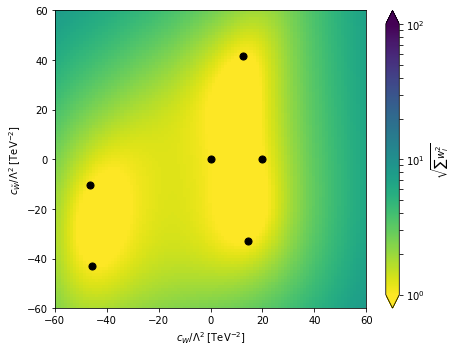

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

### 1c) Save setup

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [8]:
miner.save('data/madminer_example.h5')

They can now be loaded again with `miner.load(filename)`.